In [1]:
!apt-get install nvidia-cuda-toolkit

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cpp-6 fonts-dejavu-core fonts-dejavu-extra g++-6 gcc-6 gcc-6-base
  libaccinj64-9.1 libasan3 libatk-wrapper-java libatk-wrapper-java-jni
  libcublas9.1 libcudart9.1 libcufft9.1 libcufftw9.1 libcuinj64-9.1
  libcurand9.1 libcusolver9.1 libcusparse9.1 libgail-common libgail18
  libgcc-6-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libnppc9.1
  libnppial9.1 libnppicc9.1 libnppicom9.1 libnppidei9.1 libnppif9.1
  libnppig9.1 libnppim9.1 libnppist9.1 libnppisu9.1 libnppitc9.1 libnpps9.1
  libnvblas9.1 libnvgraph9.1 libnvrtc9.1 libnvtoolsext1 libnvvm3
  libstdc++-6-dev libthrust-dev libvdpau-dev libxxf86dga1 nvidia-cuda-dev
  nvidia-cuda-doc nvidia-cuda-gdb nvidia-profiler nvidia-visual-profiler
  openjdk-8-jr

In [4]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-34755dd7-7c51-d514-a7b6-6b99054d10ea)


In [5]:
!nvidia-smi

Tue Jun 18 17:30:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os

os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/lib/nvidia-cuda-toolkit/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/lib/x86_64-linux-gnu/libnvvm.so"

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from numba import cuda

## Simulate Data

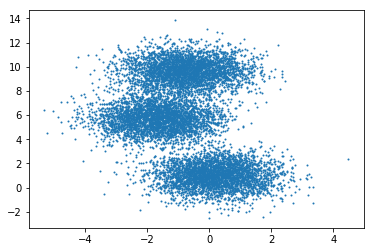

In [8]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_features = 6
blob, _ = make_blobs(n_samples=10000, n_features=n_features)
eval_points = np.linspace(-10, 10)
grid = np.meshgrid(eval_points, eval_points)
x_grid, y_grid = grid
grid = np.stack([g.flat for g in grid], axis=1)
b = np.ones((n_features,))


blob = blob.astype(np.float32)
b = b.astype(np.float32)

plt.scatter(blob[:, 0], blob[:, 1], s=1)

In [0]:
eval_points = np.concatenate((grid, blob[0, 2:] * np.ones((grid.shape[0], 1))), axis=1)
eval_points = eval_points.astype(np.float32)

## Cupy KDE

In [0]:
import math

def gaussian(x):
    return cp.exp(-0.5 * x**2) / cp.sqrt(2 * cp.pi)
  
@cp.fuse()
def cupy_kde(eval_points, samples, bandwidths):
  eval_points = cp.asarray(eval_points)
  samples = cp.asarray(samples)
  bandwidths = cp.asarray(bandwidths)
  
  return cp.asnumpy(cp.mean(
      cp.prod(
          gaussian(((cp.expand_dims(eval_points, axis=0) - cp.expand_dims(samples, axis=1)) / bandwidths)),
      axis=-1),
      axis=0) / cp.prod(bandwidths))

In [0]:
result = cupy_kde(eval_points, blob, b)

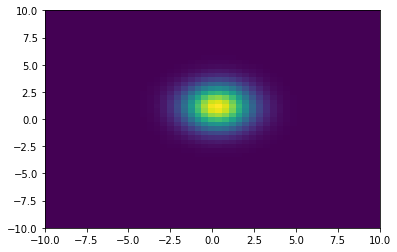

In [12]:
plt.pcolormesh(x_grid, y_grid, result.reshape((50, 50)))

In [13]:
%timeit cp.cuda.stream.get_current_stream().synchronize(); cupy_kde(eval_points, blob, b); cp.cuda.stream.get_current_stream().synchronize();

10 loops, best of 3: 59.6 ms per loop


In [45]:
from sklearn.neighbors import KernelDensity

np.allclose(np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)), cupy_kde(eval_points, blob, b))

True

## NUMBA CPU

In [0]:
import numba
import math

SQRT_2PI = np.float32(math.sqrt(2.0 * math.pi))

@numba.vectorize(['float32(float32, float32, float32)'], nopython=True, target='cpu', fastmath=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@numba.njit('float32[:](float32[:, :], float32[:, :], float32[:])', parallel=True, fastmath=True, nogil=True)
def numba_kde_multithread2(eval_points, samples, bandwidths):
    n_eval_points = len(eval_points)
    result = np.zeros((n_eval_points,), dtype=np.float32)
    n_samples = len(samples)
    denom = n_samples * np.prod(bandwidths)

    for i in numba.prange(n_eval_points):
        for j in range(n_samples):
            result[i] += np.prod(
                gaussian_pdf(eval_points[i], samples[j], bandwidths))
        result[i] /= denom

    return result


result = numba_kde_multithread2(eval_points, blob, b)

In [26]:
%timeit numba_kde_multithread2(eval_points, blob, b)

1 loop, best of 3: 2.91 s per loop


## NUMBA CUDA GPU
+ One eval point only

In [0]:
from numba import cuda
import math

SQRT_2PI = np.float32(math.sqrt(2.0 * math.pi))


@cuda.jit(device=True, inline=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@cuda.jit
def numba_kde_cuda(eval_points, samples, bandwidths, out):
    thread_id = cuda.grid(1)
    stride = cuda.gridsize(1)
    n_samples = samples.shape[0]

    for sample_ind in range(thread_id, n_samples, stride):
        diff = 1.0
        for bandwidth_ind in range(bandwidths.shape[0]):
            diff *= (gaussian_pdf(eval_points[0, bandwidth_ind],
                                  samples[sample_ind, bandwidth_ind],
                                  bandwidths[bandwidth_ind])
                     / bandwidths[bandwidth_ind])
        diff /= n_samples
        cuda.atomic.add(out, 0, diff)

In [28]:
out = np.zeros((1,), dtype=np.float32)

threads_per_block = 64
n_eval_points = 1
n_train, n_test = blob.shape[0], n_eval_points
blocks_per_grid = ((n_train * n_test) + (threads_per_block - 1)) // threads_per_block


numba_kde_cuda[blocks_per_grid, threads_per_block](eval_points[[0]], blob, b, out)

print(out)

[3.2279072e-36]


In [29]:
numba_kde_multithread2(eval_points, blob, b)[0]

3.23877e-36

## NUMBA CUDA GPU2
+ All eval points (one spike, all position bins)
+ Using atomic add

In [0]:
@cuda.jit
def numba_kde_cuda2(eval_points, samples, bandwidths, out):
    thread_id1, thread_id2 = cuda.grid(2)
    stride1, stride2 = cuda.gridsize(2)
    (n_eval, n_bandwidths), n_samples = eval_points.shape, samples.shape[0]

    for eval_ind in range(thread_id1, n_eval, stride1):
        for sample_ind in range(thread_id2, n_samples, stride2):
            diff = 1.0
            for bandwidth_ind in range(n_bandwidths):
                diff *= (gaussian_pdf(eval_points[eval_ind, bandwidth_ind],
                                      samples[sample_ind, bandwidth_ind],
                                      bandwidths[bandwidth_ind])
                         / bandwidths[bandwidth_ind])
            diff /= n_samples
            cuda.atomic.add(out, eval_ind, diff)

In [0]:
n_eval_points = eval_points.shape[0]
out = np.zeros((n_eval_points,), dtype=np.float32)
n_train, n_test = blob.shape[0], n_eval_points

threads_per_block = 16, 16
blocks_per_grid_x = math.ceil(n_test / threads_per_block[0])
blocks_per_grid_y = math.ceil(n_train / threads_per_block[1])
blocks_per_grid = blocks_per_grid_x, blocks_per_grid_y


numba_kde_cuda2[blocks_per_grid, threads_per_block](eval_points, blob, b, out)

In [32]:
np.allclose(numba_kde_multithread2(eval_points, blob, b), out)

True

In [33]:
from sklearn.neighbors import KernelDensity

np.allclose(np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)), out)

True

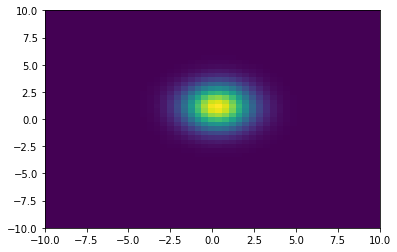

In [34]:
result = np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points))

plt.pcolormesh(x_grid, y_grid, result.reshape((50, 50)))

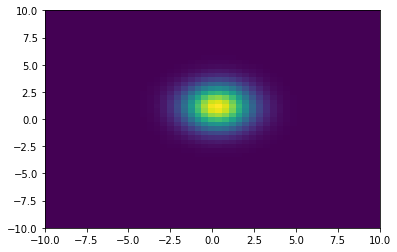

In [35]:
plt.pcolormesh(x_grid, y_grid, out.reshape((50, 50)))

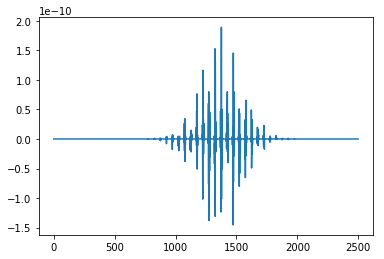

In [36]:
plt.plot(out - numba_kde_multithread2(eval_points, blob, b))

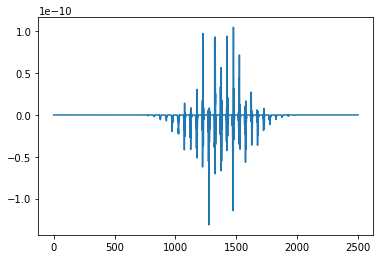

In [37]:
plt.plot(out - np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)))

In [38]:
%timeit cuda.synchronize(); numba_kde_cuda2[blocks_per_grid, threads_per_block](eval_points, blob, b, out); cuda.synchronize()

10 loops, best of 3: 46.8 ms per loop


In [39]:
%timeit KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)

1 loop, best of 3: 1.42 s per loop


In [40]:
%timeit numba_kde_multithread2(eval_points, blob, b)

1 loop, best of 3: 2.96 s per loop


## NUMBA CUDA GPU3
+ Loop over all spikes and covariate bins
+ Using atomic add

In [0]:
@cuda.jit
def numba_kde_cuda3(covariate_bins, marks, samples, bandwidths, out):
    thread_id1, thread_id2, thread_id3 = cuda.grid(3)
    stride1, stride2, stride3 = cuda.gridsize(3)

    n_bins, n_cov = covariate_bins.shape
    n_test, n_features = marks.shape
    n_samples = samples.shape[0]

    for test_ind in range(thread_id1, n_test, stride1):
        for bin_ind in range(thread_id2, n_bins, stride2):
            for sample_ind in range(thread_id3, n_samples, stride3):
                diff = 1.0
                
                for cov_ind in range(n_cov):
                    diff *= (gaussian_pdf(covariate_bins[bin_ind, cov_ind],
                                          samples[sample_ind, cov_ind],
                                          bandwidths[cov_ind])
                             / bandwidths[cov_ind])

                for feature_ind in range(n_features):
                    diff *= (gaussian_pdf(marks[test_ind, feature_ind],
                                          samples[sample_ind,
                                                  n_cov + feature_ind],
                                          bandwidths[n_cov + feature_ind])
                             / bandwidths[n_cov + feature_ind])

                diff /= n_samples
                
                cuda.atomic.add(out, (test_ind, bin_ind), diff)

In [0]:
# n_samples, n_test = blob.shape[0], blob.shape[0]
# n_bins, n_cov = grid.shape
# n_marks = 4
# out = np.zeros((n_test, n_bins))


# threads_per_block = 4, 8, 4
# blocks_per_grid_x = math.ceil(n_test / threads_per_block[0])
# blocks_per_grid_y = math.ceil(n_bins / threads_per_block[1])
# blocks_per_grid_z = math.ceil(n_samples / threads_per_block[2])
# blocks_per_grid = blocks_per_grid_x, blocks_per_grid_y, blocks_per_grid_z


# numba_kde_cuda3[blocks_per_grid, threads_per_block](grid, np.ascontiguousarray(blob[:n_test, n_cov:]), blob, b, out)

In [0]:
# np.allclose(out[0], np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)))

In [0]:
# plt.pcolormesh(x_grid, y_grid, out[0].reshape((50, 50)))

In [0]:
# %timeit cuda.synchronize(); numba_kde_cuda3[blocks_per_grid, threads_per_block](grid, np.ascontiguousarray(blob[:n_test, n_cov:]), blob, b, out); cuda.synchronize()

In [0]:
# import numba
# import math

# SQRT_2PI = np.float64(math.sqrt(2.0 * math.pi))

# @numba.vectorize(['float64(float64, float64, float64)'], nopython=True, target='cpu')
# def gaussian_pdf(x, mean, sigma):
#     '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
#     return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


# @numba.njit('float64[:, :](float64[:, :], float64[:, :], float64[:, :], float64[:])', parallel=True, fastmath=True)
# def numba_kde_multithread3(covariate_bins, marks, samples, bandwidths):
#     n_bins, n_cov = covariate_bins.shape
#     n_test, n_features = marks.shape
#     n_samples = samples.shape[0]
#     result = np.zeros((n_test, n_bins))
    
#     for test_ind in numba.prange(n_test):
#         for bin_ind in range(n_bins):
#             for sample_ind in range(n_samples):
#                 diff = 1.0
                
#                 for cov_ind in range(n_cov):
#                     diff *= (gaussian_pdf(covariate_bins[bin_ind, cov_ind],
#                                           samples[sample_ind, cov_ind],
#                                           bandwidths[cov_ind])
#                              / bandwidths[cov_ind])

#                 for feature_ind in range(n_features):
#                     diff *= (gaussian_pdf(marks[test_ind, feature_ind],
#                                           samples[sample_ind,
#                                                   n_cov + feature_ind],
#                                           bandwidths[n_cov + feature_ind])
#                              / bandwidths[n_cov + feature_ind])
#                 result[test_ind, bin_ind] += diff / n_samples

#     return result

# n_samples, n_test = blob.shape[0], blob.shape[0]
# n_bins, n_cov = grid.shape


In [0]:
# result = numba_kde_multithread3(grid, np.ascontiguousarray(blob[:2, n_cov:]), blob, b)
# np.allclose(result[0], np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)))

In [0]:
# plt.plot(result[0] - np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)))

In [0]:
# fig, axes = plt.subplots(1, 2)
# axes[0].pcolormesh(x_grid, y_grid, result[0].reshape((50, 50)))
# axes[1].pcolormesh(x_grid, y_grid, np.exp(KernelDensity(bandwidth=b[0]).fit(blob).score_samples(eval_points)).reshape((50, 50)))

In [0]:
# %timeit numba_kde_multithread3(grid, np.ascontiguousarray(blob[:n_test, n_cov:]), blob, b)

## NUMBA CUDA GPU 2a
+ All eval points (one spike, all covariate bins)
+ Avoid atomic add

In [46]:
from numba import cuda
import math

SQRT_2PI = np.float32(math.sqrt(2.0 * math.pi))


@cuda.jit(device=True, inline=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


@cuda.jit
def numba_kde_cuda2a(eval_points, samples, bandwidths, out):
  n_samples, n_bandwidths = samples.shape
  thread_id = cuda.grid(1)
  sum_kernel = 0.0

  for sample_ind in range(n_samples):
    product_kernel = 1.0
    for bandwidth_ind in range(n_bandwidths):
      product_kernel *= (
            gaussian_pdf(eval_points[thread_id, bandwidth_ind],
                         samples[sample_ind, bandwidth_ind],
                         bandwidths[bandwidth_ind])
            / bandwidths[bandwidth_ind])
    sum_kernel += product_kernel

  out[thread_id] = sum_kernel / n_samples
  

n_eval_points = eval_points.shape[0]
threads_per_block = 64
blocks_per_grid_x = math.ceil(n_eval_points / threads_per_block)
blocks_per_grid = blocks_per_grid_x

out = np.zeros((n_eval_points,), dtype=np.float32)
numba_kde_cuda2a[blocks_per_grid, threads_per_block](eval_points, blob, b, out)
np.allclose(numba_kde_multithread2(eval_points, blob, b), out)

True

In [47]:
%timeit cuda.synchronize(); numba_kde_cuda2a[blocks_per_grid, threads_per_block](eval_points, blob, b, out); cuda.synchronize()

1 loop, best of 3: 87.7 ms per loop


## NUMBA CUDA GPU 2b
+ All eval points (one spike, all covariate bins)
+ Avoid atomic add
+ Use tiling

### Numba KDE CUDA GPU3a

In [0]:
from numba import cuda
from numba.types import float64, float32
import math

SQRT_2PI = np.float32(math.sqrt(2.0 * math.pi))


@cuda.jit(device=True, inline=True)
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)


TILE_SIZE = 64


@cuda.jit
def numba_kde_cuda2c(eval_points, samples, bandwidths, out, out2):
    '''

    Parameters
    ----------
    eval_points : ndarray, shape (n_eval, n_bandwidths)
    samples : ndarray, shape (n_samples, n_bandwidths)
    out : ndarray, shape (n_eval,)

    '''
    n_eval, n_bandwidths = eval_points.shape
    n_samples = samples.shape[0]

    thread_id1, thread_id2 = cuda.grid(2)

    relative_thread_id1 = cuda.threadIdx.x
    relative_thread_id2 = cuda.threadIdx.y
    n_threads = cuda.blockDim.x

    samples_tile = cuda.shared.array((TILE_SIZE, 6), float32)

    sum_kernel = 0.0

    for tile_ind in range(0, n_samples, TILE_SIZE):
        tile_index = tile_ind * TILE_SIZE + relative_thread_id2

        for i in range(0, TILE_SIZE, n_threads):
          for bandwidth_ind in range(n_bandwidths):
              samples_tile[relative_thread_id2 + i, bandwidth_ind] = samples[
                  tile_index + i, bandwidth_ind]
              out2[tile_index + i, bandwidth_ind] = samples[tile_index + i, bandwidth_ind]

        cuda.syncthreads()

        if tile_index < n_samples:
            product_kernel = 1.0
            for bandwidth_ind in range(n_bandwidths):
                product_kernel *= (
                    gaussian_pdf(eval_points[thread_id1, bandwidth_ind],
                                 samples_tile[relative_thread_id2,
                                              bandwidth_ind],
                                 bandwidths[bandwidth_ind])
                    / bandwidths[bandwidth_ind])
            sum_kernel += product_kernel

        cuda.syncthreads()

    out[thread_id1] = sum_kernel / n_samples


# Allocate shared memory dynamically by setting shape = 0 and
#. kernel[grid_dim, block_dim, stream, dyn_shared_size](*kernel_args)
# If not using streams use 0


In [0]:
n_eval_points = eval_points.shape[0]
out = np.zeros((n_eval_points,), dtype=np.float32)

n_train, n_test = blob.shape[0], n_eval_points
out2 = np.zeros((n_train, 6), dtype=np.float32)

threads_per_block = 16, 16
blocks_per_grid_x = math.ceil(n_test / threads_per_block[0])
blocks_per_grid_y = math.ceil(n_train / threads_per_block[1])
blocks_per_grid = blocks_per_grid_x, blocks_per_grid_y


numba_kde_cuda2c[blocks_per_grid, threads_per_block](eval_points, blob, b, out, out2)
result = numba_kde_multithread2(eval_points, blob, b)
np.allclose(result, out)

False

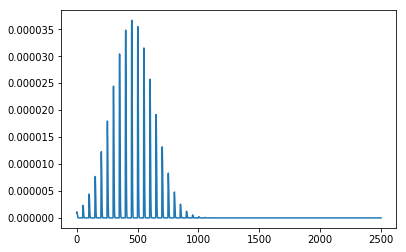

In [0]:
plt.plot(result - out)

In [0]:
%timeit cuda.synchronize(); numba_kde_cuda2c[blocks_per_grid, threads_per_block](eval_points, blob, b, out); cuda.synchronize()

TypeError: ignored

In [0]:
np.nonzero(out2.sum(axis=1))[0]

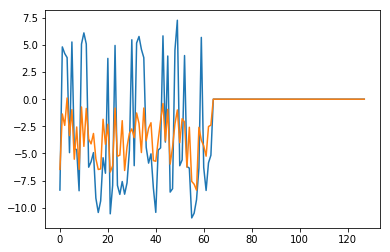

In [0]:
plt.plot(out2[:128, 0])
plt.plot(out2[:128, 1])

In [0]:
out2[:128]

array([[0.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [2.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [3.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [4.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [5.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [6.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [7.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [8.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [9.000e+00, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+01, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.100e+01, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.200e+01, 9.990e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.300e+01, 9.990e

In [0]:
blocks_per_grid

(157, 625)